### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C

!pip install quantstats
import quantstats as qs

### Create Env

In [2]:
# df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

import yfinance as yf

tsla = yf.Ticker("TSLA")
df = tsla.history(period="max")

window_size = 10
start_index = window_size
end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


### Train Env

In [3]:
env.reset(seed=2023)
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=1_000)

### Test Env

In [4]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 2064, <Actions.Buy: 1>: 1391}
info: {'total_reward': 22.757816076278687, 'total_profit': 2.5950764076197875e-05, 'position': <Positions.Short: 0>}


### Plot Results

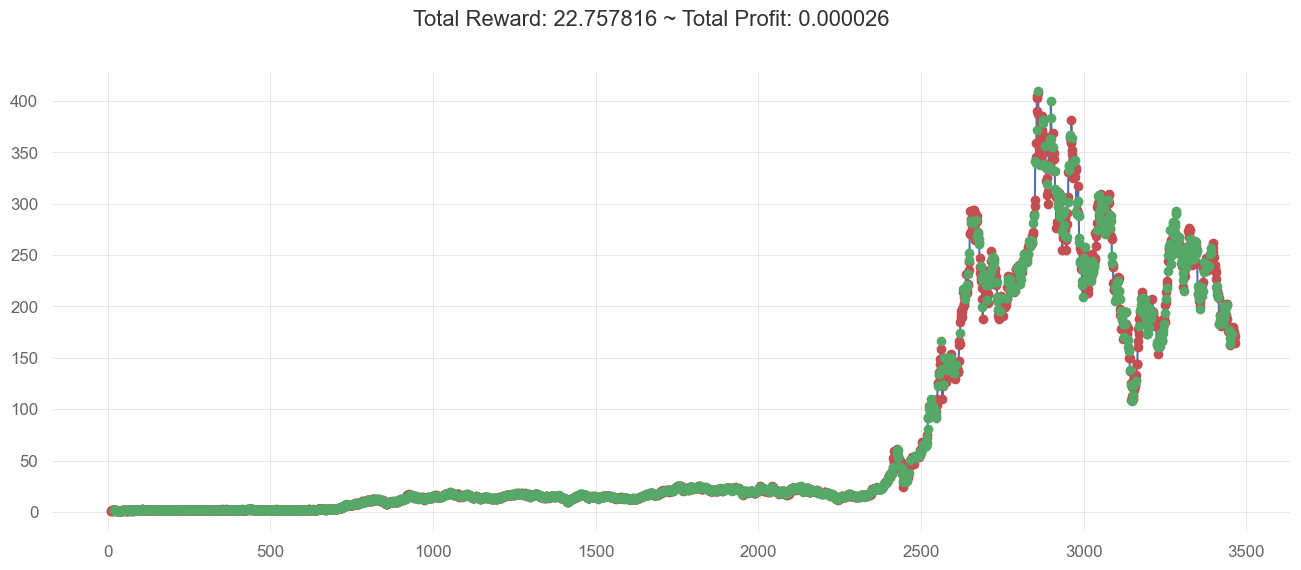

In [5]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

### Analysis Using `quantstats`

                           Strategy
-------------------------  ----------
Start Period               2010-07-16
End Period                 2024-04-05
Risk-Free Rate             0.0%
Time in Market             24.0%

Cumulative Return          -100.0%
CAGR﹪                     -41.19%

Sharpe                     -2.01
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -1.98
Sortino                    -2.5
Smart Sortino              -2.46
Sortino/√2                 -1.77
Smart Sortino/√2           -1.74
Omega                      0.47

Max Drawdown               -100.0%
Longest DD Days            4989
Volatility (ann.)          35.14%
Calmar                     -0.41
Skew                       -0.29
Kurtosis                   25.11

Expected Daily %           -0.31%
Expected Monthly %         -6.16%
Expected Yearly %          -50.54%
Kelly Criterion            -37.28%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.92%
Expected Shortfall (cVaR)  -3.92%

Max Consecut

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2010-08-09,2024-03-14,2024-04-05,4989,-99.997538,-99.997228
2,2010-07-29,2010-07-29,2010-08-02,5,-3.253967,NaN


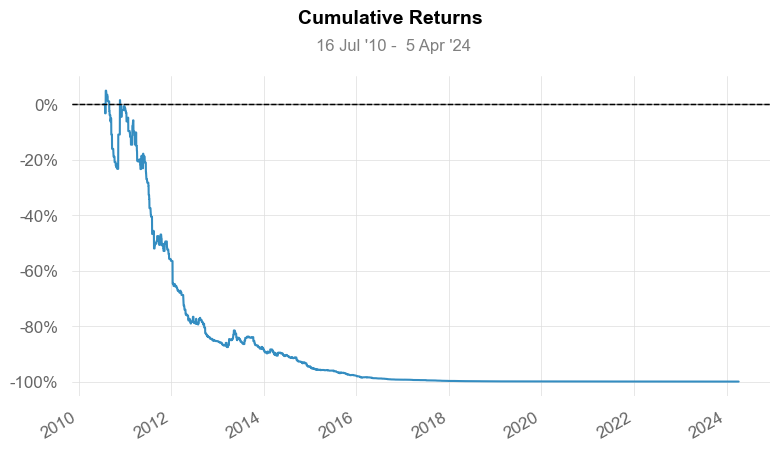

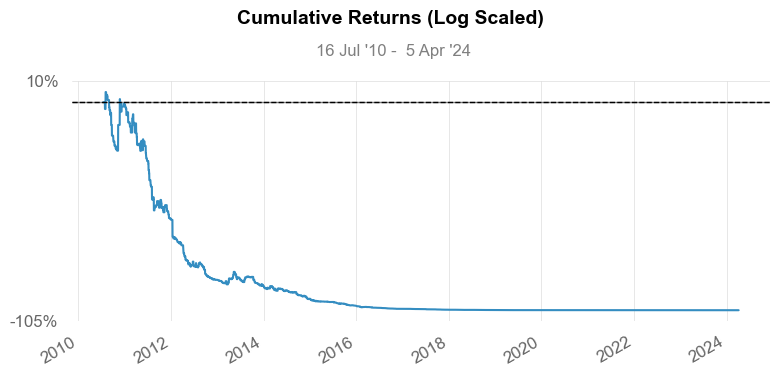

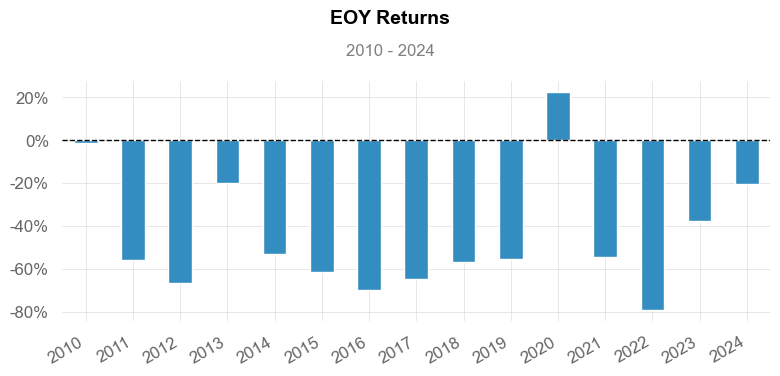

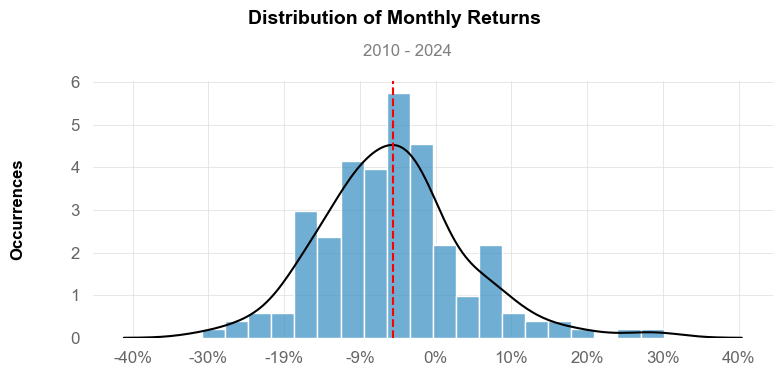

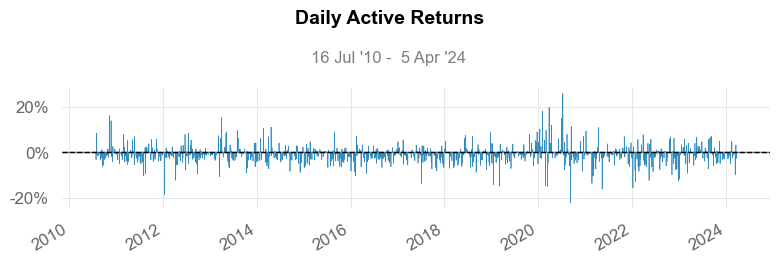

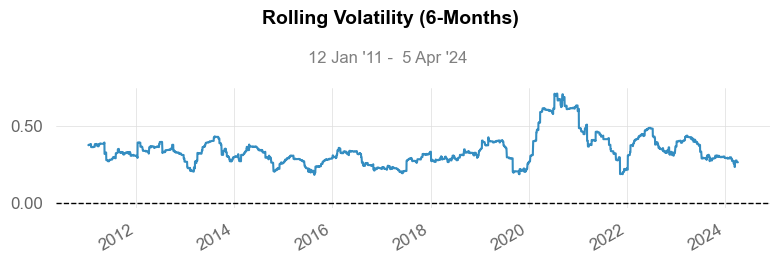

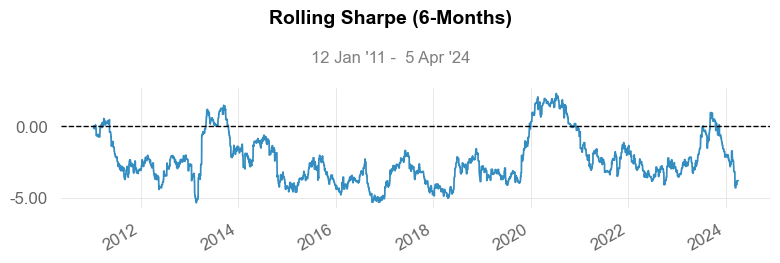

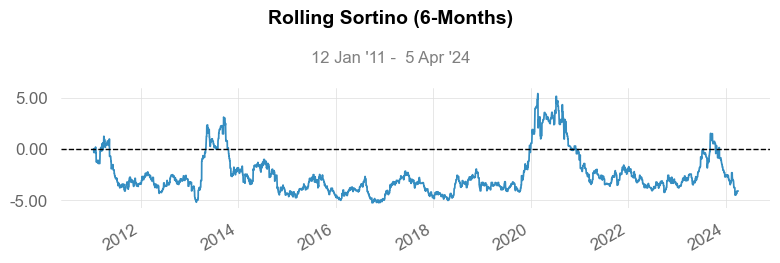

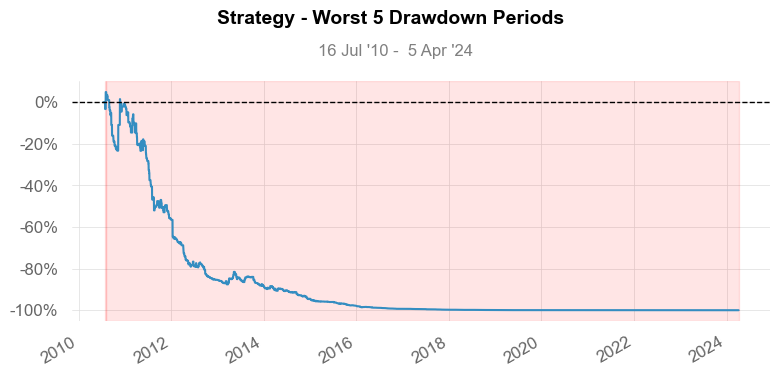

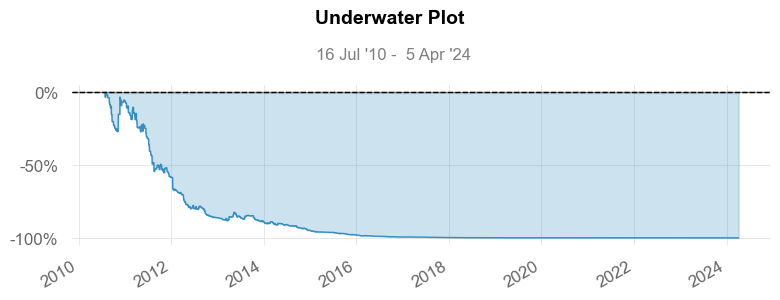

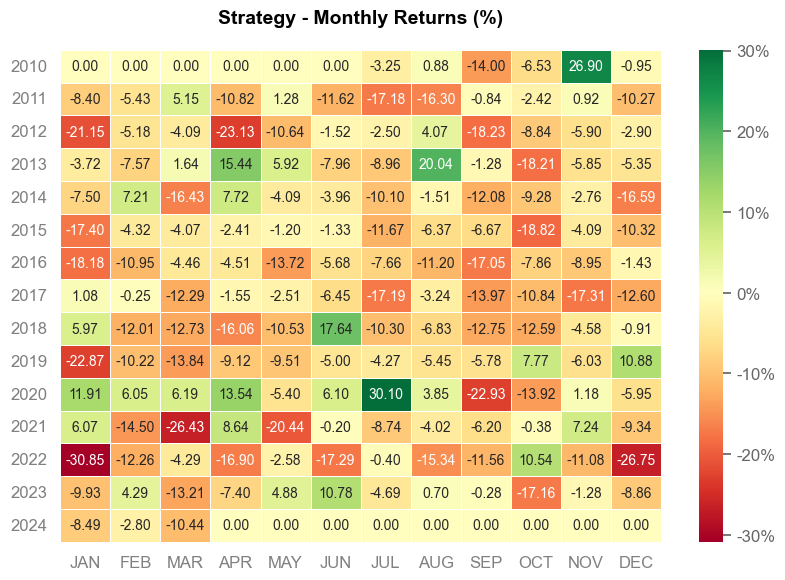

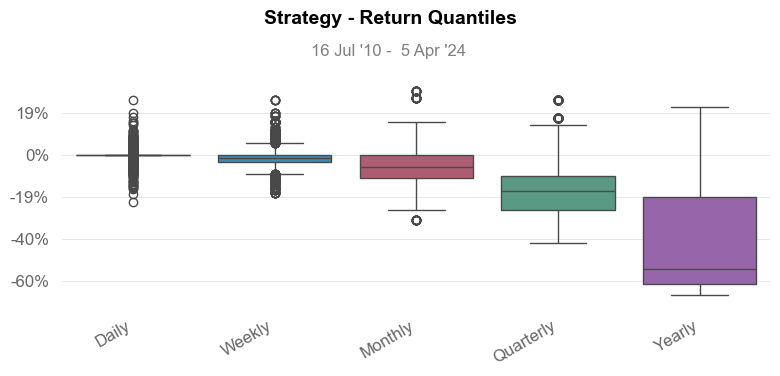

In [6]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')